In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix
import math
import xgboost as xgb
from scipy.stats import skew
from scipy import stats
import statsmodels
from sklearn.metrics import accuracy_score

import sklearn
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

%matplotlib inline

In [13]:
train = pd.read_csv("../datasets/train.csv")
test = pd.read_csv("../datasets/test.csv")

# full_data = [train, test]

In [14]:
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

In [15]:
train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [17]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


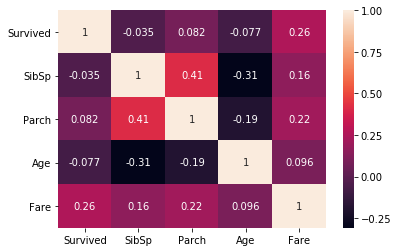

In [18]:
 g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True)

In [24]:
def compare_values(data, var1, var2):
    print(data[[var1, var2]][data[var2].isnull()==False].groupby([var1],
    as_index=False).median().sort_values(by=var2, ascending=False))
    g = sns.FacetGrid(data, col=var2).map(sns.distplot, var1)

   Parch  Survived
1      1       1.0
3      3       1.0
2      2       0.5
0      0       0.0
4      4       0.0
5      5       0.0
6      6       0.0


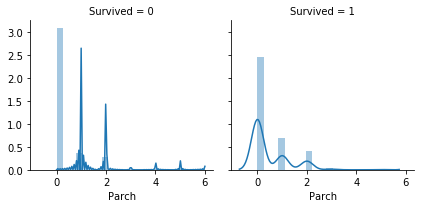

In [25]:
compare_values(train, 'Parch', 'Survived')

In [11]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [12]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [ ]:
rare_values = []

In [ ]:
train[['Title', 'Survived', 'Age']].groupby(['Title'], as_index=False).mean()
facet = sns.FacetGrid(data = train, hue = "Title", legend_out=True, size = 4.5)
facet = facet.map(sns.kdeplot, "Age")
facet.add_legend();

In [ ]:
data_df.head()

In [ ]:
help(sns.heatmap)

In [ ]:
help(pd.read_csv)